In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/aleksandr/Desktop/recsys_made2023/botify_recsys/venv/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
DATA_DIR = "/Users/aleksandr/Desktop/recsys_made2023/botify_recsys/log/experiments/random/"

In [3]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

In [4]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [5]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [6]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Train LightFM

In [7]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(3853, 966)

In [8]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [9]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [10]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2023-03-31 07:49:57,318] A new study created in memory with name: no-name-add0381a-4670-4271-a5a1-08b92296e5e0
[I 2023-03-31 07:49:57,603] Trial 0 finished with value: 0.004961831960827112 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.001, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.004961831960827112.
[I 2023-03-31 07:49:57,826] Trial 1 finished with value: 0.001145038171671331 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.004961831960827112.
[I 2023-03-31 07:49:58,084] Trial 2 finished with value: 0.0010178117081522942 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.004961831960827112.
[I 2023-03-31 07:49:58,306] Trial 3 finished with value: 0.005979644134640694 and para

[I 2023-03-31 07:50:04,180] Trial 29 finished with value: 0.005597964394837618 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 18 with value: 0.0064885495230555534.


In [12]:
best_params

{'loss': 'warp',
 'no_components': 10,
 'learning_rate': 0.01,
 'max_sampled': 10,
 'user_alpha': 0.0001,
 'item_alpha': 0.0}

In [13]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.004071246832609177 +/- 0.0013824815885562682
1:	0.004452926106750965 +/- 0.0014854767485026662
2:	0.004452926106750965 +/- 0.0014429547201752308
3:	0.004707379266619682 +/- 0.0014816322879361514
4:	0.004707379266619682 +/- 0.0014816322879361514
5:	0.004452926106750965 +/- 0.0014429547201752308
6:	0.004834605846554041 +/- 0.0015005183648708579
7:	0.004961831960827112 +/- 0.0015191171783157519
8:	0.005089058540761471 +/- 0.0015774169519814194
9:	0.005089058540761471 +/- 0.0015774169519814194
10:	0.004961831960827112 +/- 0.0015191171783157519
11:	0.004961831960827112 +/- 0.0015191171783157519
Early stopiing!


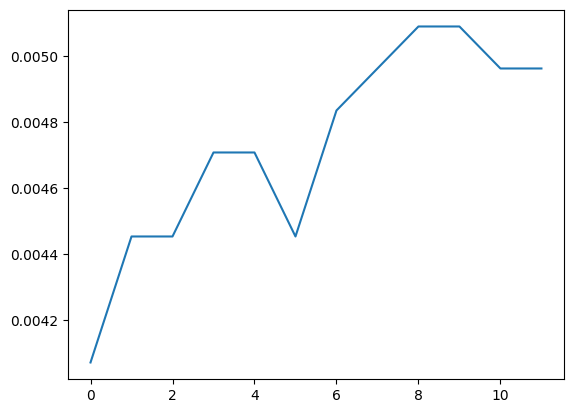

In [14]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [15]:
biases, embeddings = model.get_item_representations()

In [16]:
model.item_biases *= 0.0

In [17]:
track_meta = pd.read_json("/Users/aleksandr/Desktop/recsys_made2023/botify_recsys/data/tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [18]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [20]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [44]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [45]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7890/7890 [00:05<00:00, 1438.82it/s]
